## Load libraries

Kernel dies if I execute the following:

import os
import sys
hashseed = os.getenv('PYTHONHASHSEED')
if not hashseed:
    os.environ['PYTHONHASHSEED'] = '0'
    os.execv(sys.executable, [sys.executable] + sys.argv)

In [1]:
import os
import sys

import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps

# to be able to import from tools dir
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources"
# import pertpy as pt
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co

import warnings
warnings.filterwarnings("ignore")

In [2]:
import importlib

## Preprocessing
### Read data

In [3]:
data_path = "../../data/MOBA_scRNAseq/outs_S2"
data_all = sc.read_10x_h5(data_path + "/filtered_feature_bc_matrix.h5")
data_all

AnnData object with n_obs × n_vars = 1326 × 21982
    var: 'gene_ids', 'feature_types', 'genome'

Pseudomonas strain, all genes belong to this genome, as we're only looking at one strain:

In [4]:
data_all.var["genome"].value_counts()

genome
PAO1    21982
Name: count, dtype: int64

Number of unique genes in strain:

### Aggregate probes through max-pooling

Bedingt durch Methode bekommen wir mehr Spalten... also beziehen sich mehrere Spalten auf ein Gen.
Paper dazu siehe Slack, geht darum wie UMI reads generiert werden. Es gibt versch. Probe-Sets, die das Genom

-> Benennung: 

In [5]:
data_maxpool = up.prep_probe_BacSC_data(data_all, agg_fn=np.max)

Aggregating feature 100/5572
Aggregating feature 200/5572
Aggregating feature 300/5572
Aggregating feature 400/5572
Aggregating feature 500/5572
Aggregating feature 600/5572
Aggregating feature 700/5572
Aggregating feature 800/5572
Aggregating feature 900/5572
Aggregating feature 1000/5572
Aggregating feature 1100/5572
Aggregating feature 1200/5572
Aggregating feature 1300/5572
Aggregating feature 1400/5572
Aggregating feature 1500/5572
Aggregating feature 1600/5572
Aggregating feature 1700/5572
Aggregating feature 1800/5572
Aggregating feature 1900/5572
Aggregating feature 2000/5572
Aggregating feature 2100/5572
Aggregating feature 2200/5572
Aggregating feature 2300/5572
Aggregating feature 2400/5572
Aggregating feature 2500/5572
Aggregating feature 2600/5572
Aggregating feature 2700/5572
Aggregating feature 2800/5572
Aggregating feature 2900/5572
Aggregating feature 3000/5572
Aggregating feature 3100/5572
Aggregating feature 3200/5572
Aggregating feature 3300/5572
Aggregating feature

In [6]:
data_maxpool

AnnData object with n_obs × n_vars = 1326 × 5572
    var: 'feature_types', 'genome'

In [7]:
data_maxpool.var_names

Index(['PA0001', 'PA0002', 'PA0003', 'PA0004', 'PA0005', 'PA0006', 'PA0007',
       'PA0008', 'PA0009', 'PA0010',
       ...
       'PA5561', 'PA5562', 'PA5563', 'PA5564', 'PA5565', 'PA5566', 'PA5567',
       'PA5568', 'PA5569', 'PA5570'],
      dtype='object', length=5572)

In [8]:
sc.pp.calculate_qc_metrics(data_maxpool, var_type="genes", percent_top=None, log1p=True, inplace=True)
data_maxpool

AnnData object with n_obs × n_vars = 1326 × 5572
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [9]:
print(f"Zero inflation of probe-wise data: {((np.prod(data_all.X.shape) - data_all.X.getnnz()) / np.prod(data_all.X.shape)).round(3)}")
print(f"Zero inflation of aggregated data: {((np.prod(data_maxpool.X.shape) - data_maxpool.X.getnnz()) / np.prod(data_maxpool.X.shape)).round(3)}")


Zero inflation of probe-wise data: 0.947
Zero inflation of aggregated data: 0.856


## Attach transcription units

tu = pd.read_csv("../../data/MOBA_scRNAseq/PAO1 gene ID and TU.csv")
tu

data_maxpool.var = pd.merge(data_maxpool.var, tu, left_index=True, right_on="PAO1_ID")
data_maxpool.var.index = data_maxpool.var["PAO1_ID"]
data_maxpool.var

## Filter cells

Filter based on median absolute standard deviation:

- log1p_total_counts: count depth (number of counts per barcode)
- log1p_n_genes_by_counts: number of detected genes by barcode

Filter genes based on:
- min_cells = 2: at least gene is expressed in 2 cells

Further, filter cells based on:
- min_genes: at least 2 genes have to be expressed

In [10]:
importlib.reload(ut)
data_gene = ut.filter_outliers(data_maxpool, nmads=5, min_cells=2)
print(data_maxpool.obs.outlier.value_counts())
print(f"Total number of cells: {data_maxpool.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")
data_gene

outlier
False    1255
True       71
Name: count, dtype: int64
Total number of cells: 1326
Number of cells after filtering: 1255


AnnData object with n_obs × n_vars = 1255 × 5540
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

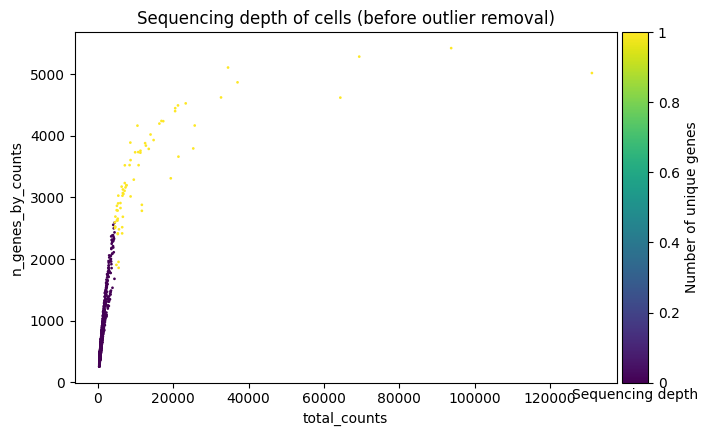

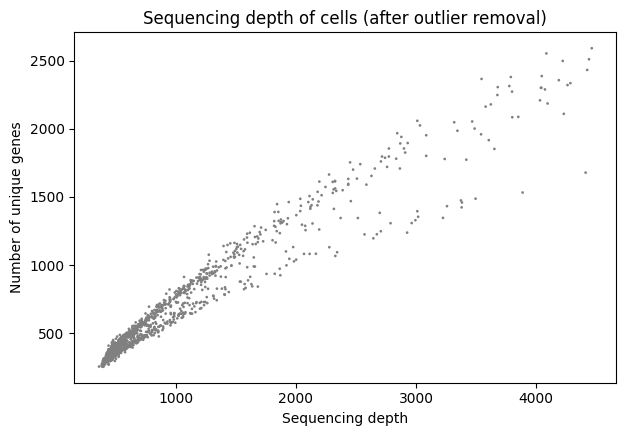

In [11]:
sc.pl.scatter(data_maxpool, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="viridis", title="Sequencing depth of cells (before outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15)
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

## Variance stabilization

Plotting the mean-variance ratio of genes, we see that the data is clearly overdispersed. Therefore, we will use negative binomial count splitting

In [12]:
data_gene.layers["counts"] = data_gene.X.copy()

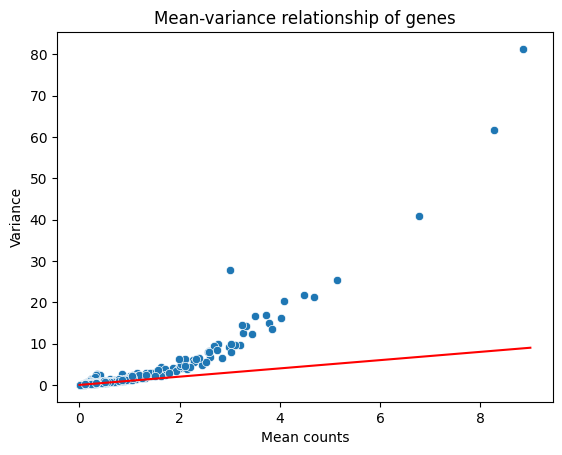

In [13]:
data_gene.var["var_counts"] = np.asarray(np.var(data_gene.X.toarray(), axis=0)).squeeze()
data_gene.var["mean_counts"] = np.asarray(np.mean(data_gene.X.toarray(), axis=0)).squeeze()
sns.scatterplot(data=data_gene.var, x="mean_counts", y="var_counts")
plt.plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
plt.title("Mean-variance relationship of genes")
plt.xlabel("Mean counts")
plt.ylabel("Variance")
plt.show()

## Estimate negative binomial parameters for each gene

In [14]:
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="BFGS")
data_gene.var["nb_overdisp_cutoff_bfgs"] = data_gene.var["nb_overdisp_cutoff"]
data_gene.var["nb_overdisp_bfgs"] = data_gene.var["nb_overdisp"]


Fitting feature 100/5540
Fitting feature 200/5540
Fitting feature 300/5540
Fitting feature 400/5540
Fitting feature 500/5540
Fitting feature 600/5540
Fitting feature 700/5540
Fitting feature 800/5540
Fitting feature 900/5540
Fitting feature 1000/5540
Fitting feature 1100/5540
Fitting feature 1200/5540
Fitting feature 1300/5540
Fitting feature 1400/5540
Fitting feature 1500/5540
Fitting feature 1600/5540
Fitting feature 1700/5540
Fitting feature 1800/5540
Fitting feature 1900/5540
Fitting feature 2000/5540
Fitting feature 2100/5540
Fitting feature 2200/5540
Fitting feature 2300/5540
Fitting feature 2400/5540
Fitting feature 2500/5540
Fitting feature 2600/5540
Fitting feature 2700/5540
Fitting feature 2800/5540
Fitting feature 2900/5540
Fitting feature 3000/5540
Fitting feature 3100/5540
Fitting feature 3200/5540
Fitting feature 3300/5540
Fitting feature 3400/5540
Fitting feature 3500/5540
Fitting feature 3600/5540
Fitting feature 3700/5540
Fitting feature 3800/5540
Fitting feature 3900/

In [15]:
data_gene

AnnData object with n_obs × n_vars = 1255 × 5540
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs'
    layers: 'counts'

<Axes: xlabel='nb_mean', ylabel='Count'>

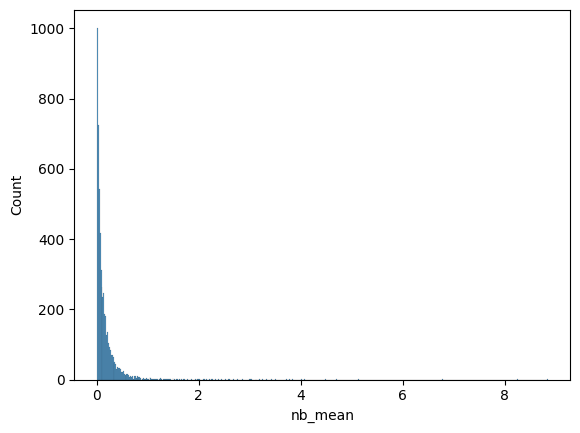

In [16]:
sns.histplot(data_gene.var["nb_mean"])

<Axes: xlabel='nb_overdisp', ylabel='Count'>

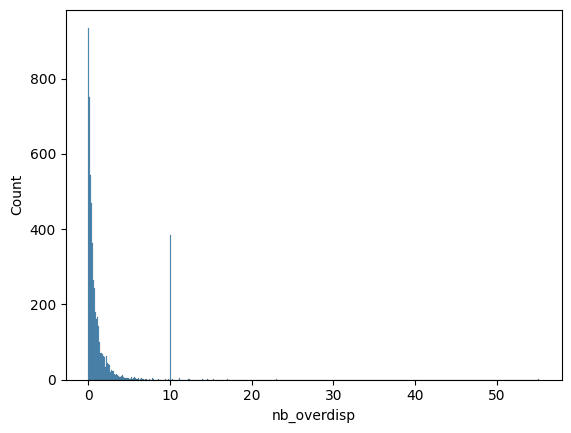

In [17]:
sns.histplot(data_gene.var["nb_overdisp"])

In [18]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="sctransform")

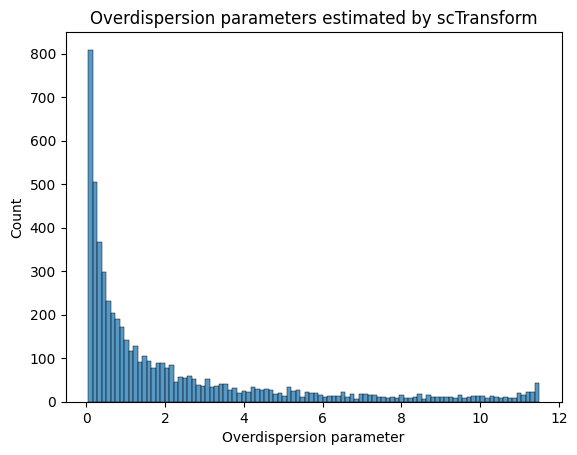

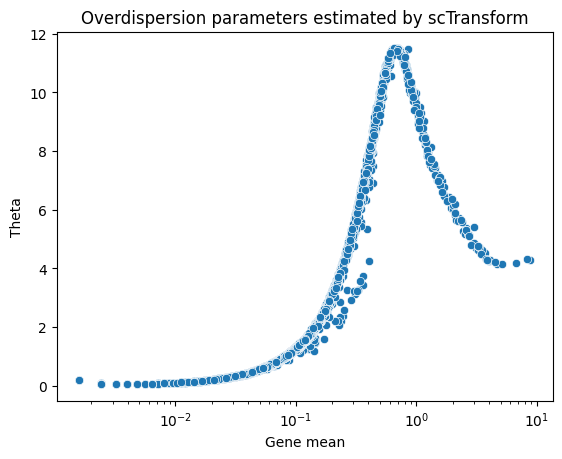

In [19]:
sns.histplot(data=data_gene.var, x="nb_overdisp_cutoff", bins=100)
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Overdispersion parameter")
plt.show()

g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log")
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

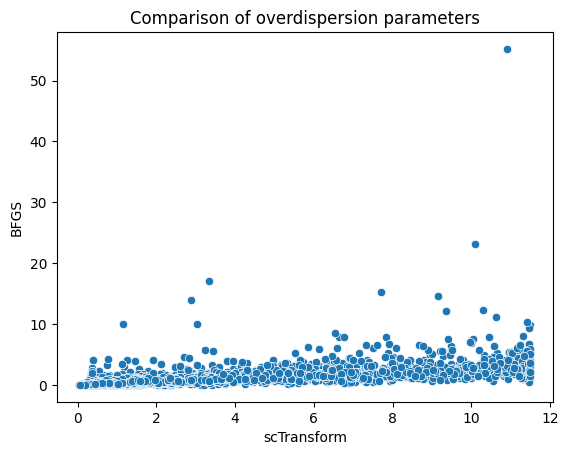

Correlation: [[1.         0.62796613]
 [0.62796613 1.        ]]


In [20]:
g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff_bfgs", x="nb_overdisp_cutoff")
plt.title("Comparison of overdispersion parameters")
plt.xlabel("scTransform")
plt.ylabel("BFGS")
plt.show()

print(f"Correlation: {np.corrcoef(data_gene.var['nb_overdisp_cutoff_bfgs'], data_gene.var['nb_overdisp_cutoff'])}")

In [21]:
data_gene.X = data_gene.layers["counts"].copy()

In [22]:
data_gene

AnnData object with n_obs × n_vars = 1255 × 5540
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs'
    layers: 'counts'

## Normalization, VST, scaling and PCA

In [23]:
# Normalizes X, such that: each barcode has total count equal to median of total counts before normalization
sc.pp.normalize_total(data_gene, target_sum=None, layer=None)

# Variance Stabilization Transformation
data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))
data_gene.layers["vst_counts"] = data_gene.X.copy()

# Scale data to unit variance and zero mean. Truncate values to 10
sc.pp.scale(data_gene, max_value=10, zero_center=True)
# data_gene.X[np.isnan(data_gene.X)] = 0

# Apply full PCA
sc.tl.pca(data_gene, svd_solver='arpack')

In [24]:
data_gene

AnnData object with n_obs × n_vars = 1255 × 5540
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs', 'mean', 'std'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'

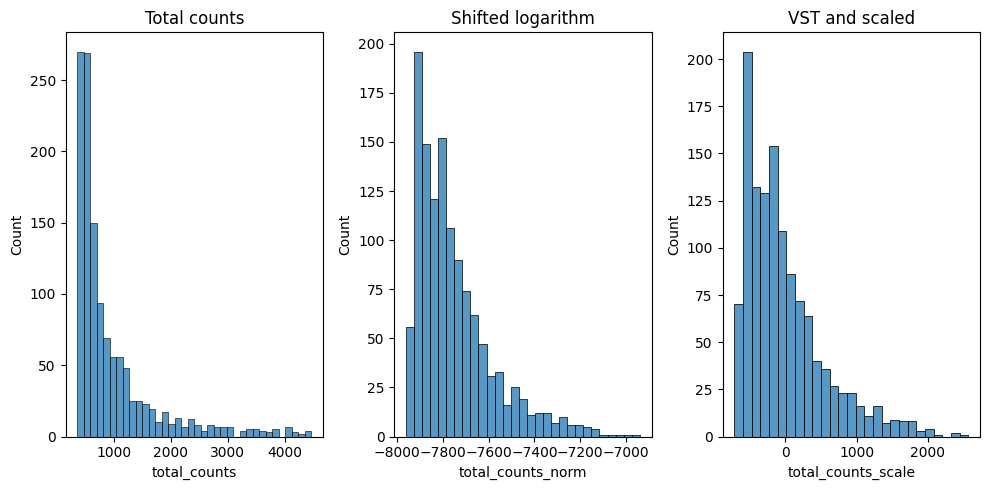

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Total counts")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("Shifted logarithm")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaled")
plt.tight_layout()
plt.show()

## Count-splitting into train and test data

In [26]:
data_train, data_test = cs.countsplit_adata(data_gene, data_dist="NB", beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=1234)
print(data_train)

AnnData object with n_obs × n_vars = 1255 × 5419
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'n_counts', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs', 'mean', 'std'
    layers: 'counts'


## Find latent dim: accelerated momentum

In [27]:
importlib.reload(cs)

<module 'tools.countsplit' from '/Users/stffn/projects/thesis_dev/BacSC/tools/countsplit.py'>

In [28]:
latent_dims_2_check_anmd = [15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

In [29]:
k_errors_anmd, k_opt_anmd = cs.select_anmd_latentdim_countsplit(data_train, data_test, potential_ks=latent_dims_2_check_anmd, do_warmstart=False)
print(f"Optimal latent dimension:{k_opt_anmd}")

################## LATENT DIM 15
Running A-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 70.801370] - 0.456438 secs
[1 : 71.019769] - 0.422753 secs
[2 : 73.695182] - 0.489790 secs
[3 : 70.491905] - 0.524785 secs
[4 : 69.740968] - 0.489012 secs
[5 : 69.457647] - 0.534611 secs
[6 : 69.296143] - 0.539580 secs
[7 : 69.187411] - 0.511994 secs
[8 : 69.115748] - 0.537461 secs
[9 : 69.064692] - 0.513757 secs
[10 : 69.042897] - 0.527244 secs
[11 : 69.016346] - 0.516383 secs
[12 : 68.964063] - 0.497832 secs
[13 : 68.928989] - 0.504673 secs
[14 : 68.903938] - 0.520706 secs
[15 : 68.886304] - 0.514622 secs
[16 : 68.874990] - 0.551631 secs
[17 : 68.875614] - 0.507004 secs
[18 : 68.868172] - 0.513250 secs
[19 : 68.861068] - 0.526545 secs
[20 : 68.853392] - 0.540722 secs
[21 : 68.844287] - 0.542806 secs
[22 : 68.832604] - 0.539850 secs
[23 : 68.818318] - 0.536928 secs
[24 : 68.802578] - 0.535545 secs
[25 : 68.785111] - 0.526191 secs
[26 : 68.766257] - 0.533687 s

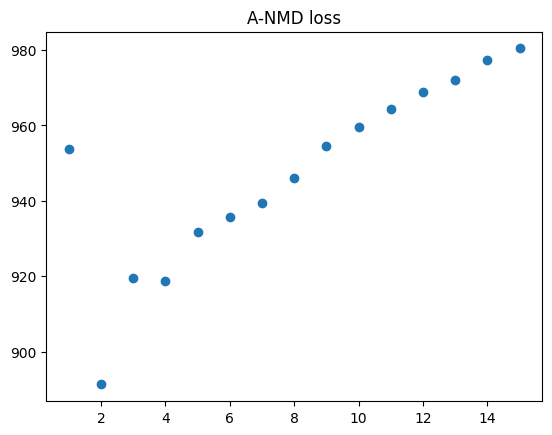

2 latent dimensions seem to be the optimum


In [30]:
plt.scatter(latent_dims_2_check_anmd, k_errors_anmd)
plt.title("A-NMD loss")
plt.show()

print(f"{k_opt_anmd} latent dimensions seem to be the optimum")

In [38]:
m, n = data_gene.X.shape
X_anmd = ut.convert_to_dense_counts(data_gene, layer="counts")
X_anmd

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 2, 1, 2],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 1, ..., 1, 2, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 1, 1, 0]])

In [39]:
W0, H0 = cs.nuclear_norm_init(X_anmd, m, n, k_opt_anmd)
Theta0 = W0 @ H0

In [41]:
from tools import NMD as nmd

In [42]:
Theta_anmd,  loss_anmd, iters_anmd, times_anmd = nmd.a_nmd(X_anmd, r=k_opt_anmd, Theta0=Theta0, tol_over_10iters=1.0e-4, gamma=1.2, gamma_bar=1.1, eta=0.4, beta=0.7,)

Running A-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 65.045837] - 0.327323 secs
[1 : 65.110323] - 0.292845 secs
[2 : 66.234845] - 0.410355 secs
[3 : 64.734949] - 0.395456 secs
[4 : 63.991970] - 0.398914 secs
[5 : 63.285178] - 0.519332 secs
[6 : 62.727711] - 0.398117 secs
[7 : 62.504102] - 0.384498 secs
[8 : 62.445922] - 0.384063 secs
[9 : 62.385789] - 0.387488 secs
[10 : 62.379436] - 0.425100 secs
[11 : 62.353851] - 0.405920 secs
[12 : 62.341223] - 0.380327 secs
[13 : 62.334100] - 0.406709 secs
[14 : 62.328161] - 0.406162 secs
[15 : 62.323898] - 0.394502 secs
[16 : 62.321689] - 0.424178 secs
[17 : 62.318923] - 0.483890 secs
[18 : 62.316628] - 0.375505 secs
[19 : 62.315214] - 0.391759 secs
[20 : 62.313943] - 0.400704 secs
[21 : 62.312825] - 0.400414 secs
[22 : 62.311901] - 0.403830 secs
[23 : 62.311829] - 0.401868 secs
[24 : 62.311344] - 0.386361 secs
[25 : 62.310927] - 0.495886 secs
[26 : 62.310531] - 0.610676 secs

Converged: abs(rel. err.(i) 

In [45]:
from scipy.sparse.linalg import svds

In [46]:
U_anmd, d_anmd, Vt_anmd = svds(Theta_anmd, 2)

In [47]:
U_anmd.shape

(1255, 2)

In [52]:
data_gene.obsm["X_anmd"] = U_anmd.copy()

<Axes: >

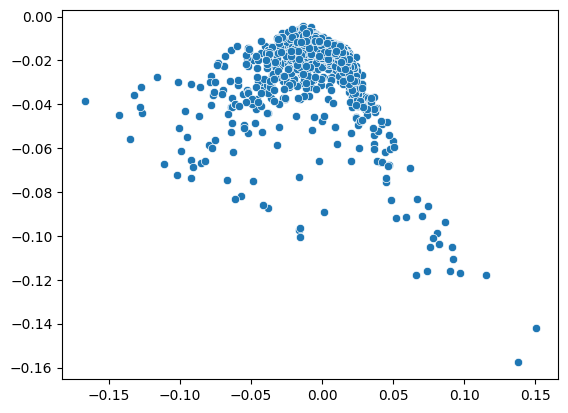

In [54]:
sns.scatterplot(data_gene.obsm["X_anmd"][:,0], data_gene.obsm["X_anmd"][:,1])

In [55]:
n_neighbors_opt = 100
min_dist_opt = 0.5

In [56]:
sc.pp.neighbors(data_gene, n_neighbors=n_neighbors_opt, n_pcs=k_opt_anmd, use_rep="X_anmd")

In [57]:
data_gene

AnnData object with n_obs × n_vars = 1255 × 5540
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs', 'mean', 'std'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca', 'X_anmd'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'distances', 'connectivities'

In [58]:
sc.tl.umap(data_gene, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)

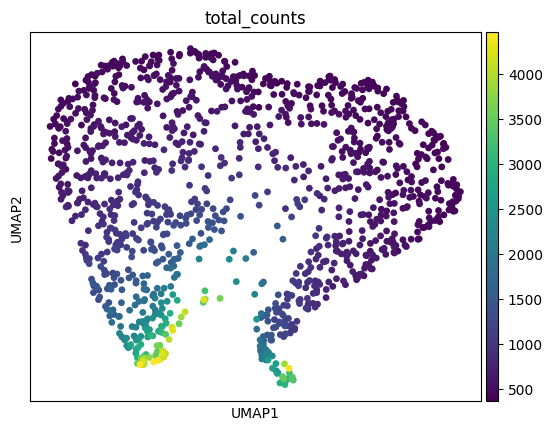

In [60]:
#sc.pl.umap(data_gene, color="embedding_reliability", alpha=1)
#plt.show()

sc.pl.umap(data_gene, color="total_counts", alpha=1, cmap="viridis")
plt.show()

In [64]:
X_anmd_train = ut.convert_to_dense_counts(data_train, layer="counts")
m, n = X_anmd_train.shape
W0_train, H0_train = cs.nuclear_norm_init(X_anmd_train, m, n, k_opt_anmd)

In [65]:
X_anmd_test = ut.convert_to_dense_counts(data_test, layer="counts")
m, n = X_anmd_test.shape
W0_test, H0_test = cs.nuclear_norm_init(X_anmd_test, m, n, k_opt_anmd)

In [67]:
Theta_train_anmd,  _, _, _ = nmd.a_nmd(X_anmd_train, r=k_opt_anmd, Theta0=W0_train @ H0_train, tol_over_10iters=1.0e-4, gamma=1.2, gamma_bar=1.1, eta=0.4, beta=0.7,)

Running A-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 78.757005] - 0.434408 secs
[1 : 78.732374] - 0.310610 secs
[2 : 79.998601] - 0.576125 secs
[3 : 78.512545] - 0.456342 secs
[4 : 77.823830] - 0.359045 secs
[5 : 77.536798] - 0.371408 secs
[6 : 77.384757] - 0.372744 secs
[7 : 77.257918] - 0.372849 secs
[8 : 77.079856] - 0.378794 secs
[9 : 76.784380] - 0.375709 secs
[10 : 76.421643] - 0.379402 secs
[11 : 76.222683] - 0.432845 secs
[12 : 76.149334] - 0.419478 secs
[13 : 76.031735] - 0.412086 secs
[14 : 75.929687] - 0.377724 secs
[15 : 75.860552] - 0.520266 secs
[16 : 75.819586] - 0.462064 secs
[17 : 75.794175] - 0.408362 secs
[18 : 75.793813] - 0.419038 secs
[19 : 75.777335] - 0.468515 secs
[20 : 75.768121] - 0.508543 secs
[21 : 75.759370] - 0.448429 secs
[22 : 75.748377] - 0.434434 secs
[23 : 75.735271] - 0.533700 secs
[24 : 75.721639] - 0.494034 secs
[25 : 75.721712] - 0.416439 secs
[26 : 75.717467] - 0.501309 secs
[27 : 75.714313] - 0.471862 s

In [68]:
Theta_test_anmd,  _, _, _ = nmd.a_nmd(X_anmd_test, r=k_opt_anmd, Theta0=W0_test @ H0_test, tol_over_10iters=1.0e-4, gamma=1.2, gamma_bar=1.1, eta=0.4, beta=0.7,)

Running A-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 77.804536] - 0.299955 secs
[1 : 77.733616] - 0.297723 secs
[2 : 78.931623] - 0.603478 secs
[3 : 77.568300] - 0.413903 secs
[4 : 76.894248] - 0.370385 secs
[5 : 76.627169] - 0.397280 secs
[6 : 76.508600] - 0.390562 secs
[7 : 76.429850] - 0.412284 secs
[8 : 76.332384] - 0.416388 secs
[9 : 76.160396] - 0.419883 secs
[10 : 75.884300] - 0.413283 secs
[11 : 75.648261] - 0.413149 secs
[12 : 75.599452] - 0.562724 secs
[13 : 75.487712] - 0.696016 secs
[14 : 75.353573] - 0.428631 secs
[15 : 75.213057] - 0.422866 secs
[16 : 75.102749] - 0.424124 secs
[17 : 75.005642] - 0.462368 secs
[18 : 74.931983] - 0.420950 secs
[19 : 74.910102] - 0.488442 secs
[20 : 74.891373] - 0.580981 secs
[21 : 74.868487] - 0.536196 secs
[22 : 74.857402] - 0.493639 secs
[23 : 74.851344] - 0.457981 secs
[24 : 74.851828] - 0.677903 secs
[25 : 74.848277] - 0.402012 secs
[26 : 74.844741] - 0.419247 secs
[27 : 74.840919] - 0.486177 s

In [69]:
data_train.obsm["X_anmd"] = Theta_train_anmd
data_test.obsm["X_anmd"] = Theta_test_anmd

2D embedding nochmal mit UMAP auf zwei Dimensionen mappen macht keinen Sinn.

In [70]:
sc.pp.neighbors(data_train, n_neighbors=n_neighbors_opt, n_pcs=k_opt_anmd, use_rep="X_anmd")
sc.tl.umap(data_train, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)

sc.pp.neighbors(data_test, n_neighbors=n_neighbors_opt, n_pcs=k_opt_anmd, use_rep="X_anmd")
sc.tl.umap(data_test, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


theta_opt, mirror_opt, umap_2_opt, ssd = ut.find_opt_umap_rotation(data_train.obsm["X_umap"].copy(), data_test.obsm["X_umap"].copy())
data_test.obsm["X_umap_rot"] = umap_2_opt

Daten könnten nur durch total_counts repräsentiert werden - liegt daran, dass nicht normalisiert wurde!

--> NMD auf counts per million (CPM) oder andere normalisierte Form der Daten, ist aber auch etwas problematisch, da viel dazugedichtet wird

Abhandlung dazu: Comparison of transformations for scRNA seq data

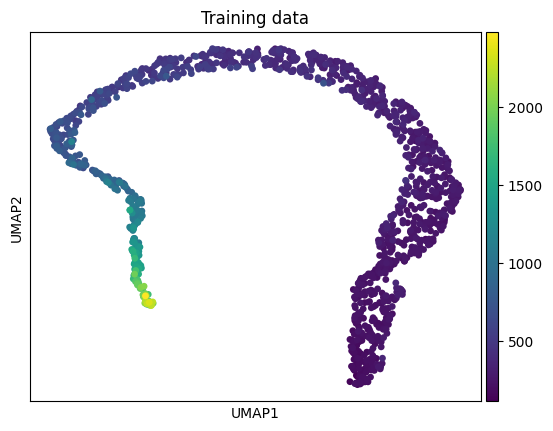

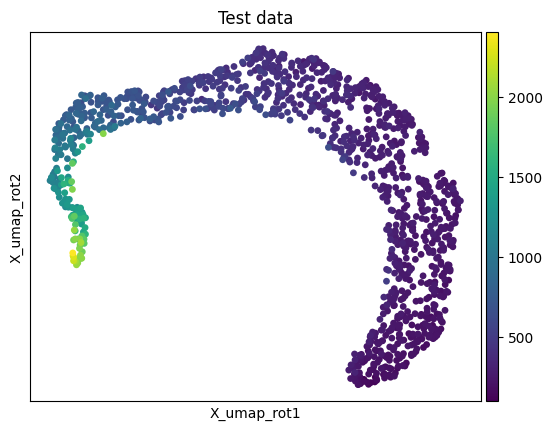

In [71]:
sc.pl.umap(data_train, color="total_counts", cmap="viridis", title="Training data")
plt.show()

sc.pl.embedding(data_test, basis="X_umap_rot", color="total_counts", cmap="viridis", title="Test data")
plt.show()

In [72]:
importlib.reload(co)
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

co.cluster_train_test(data_train, data_test, resolutions, alg="leiden")

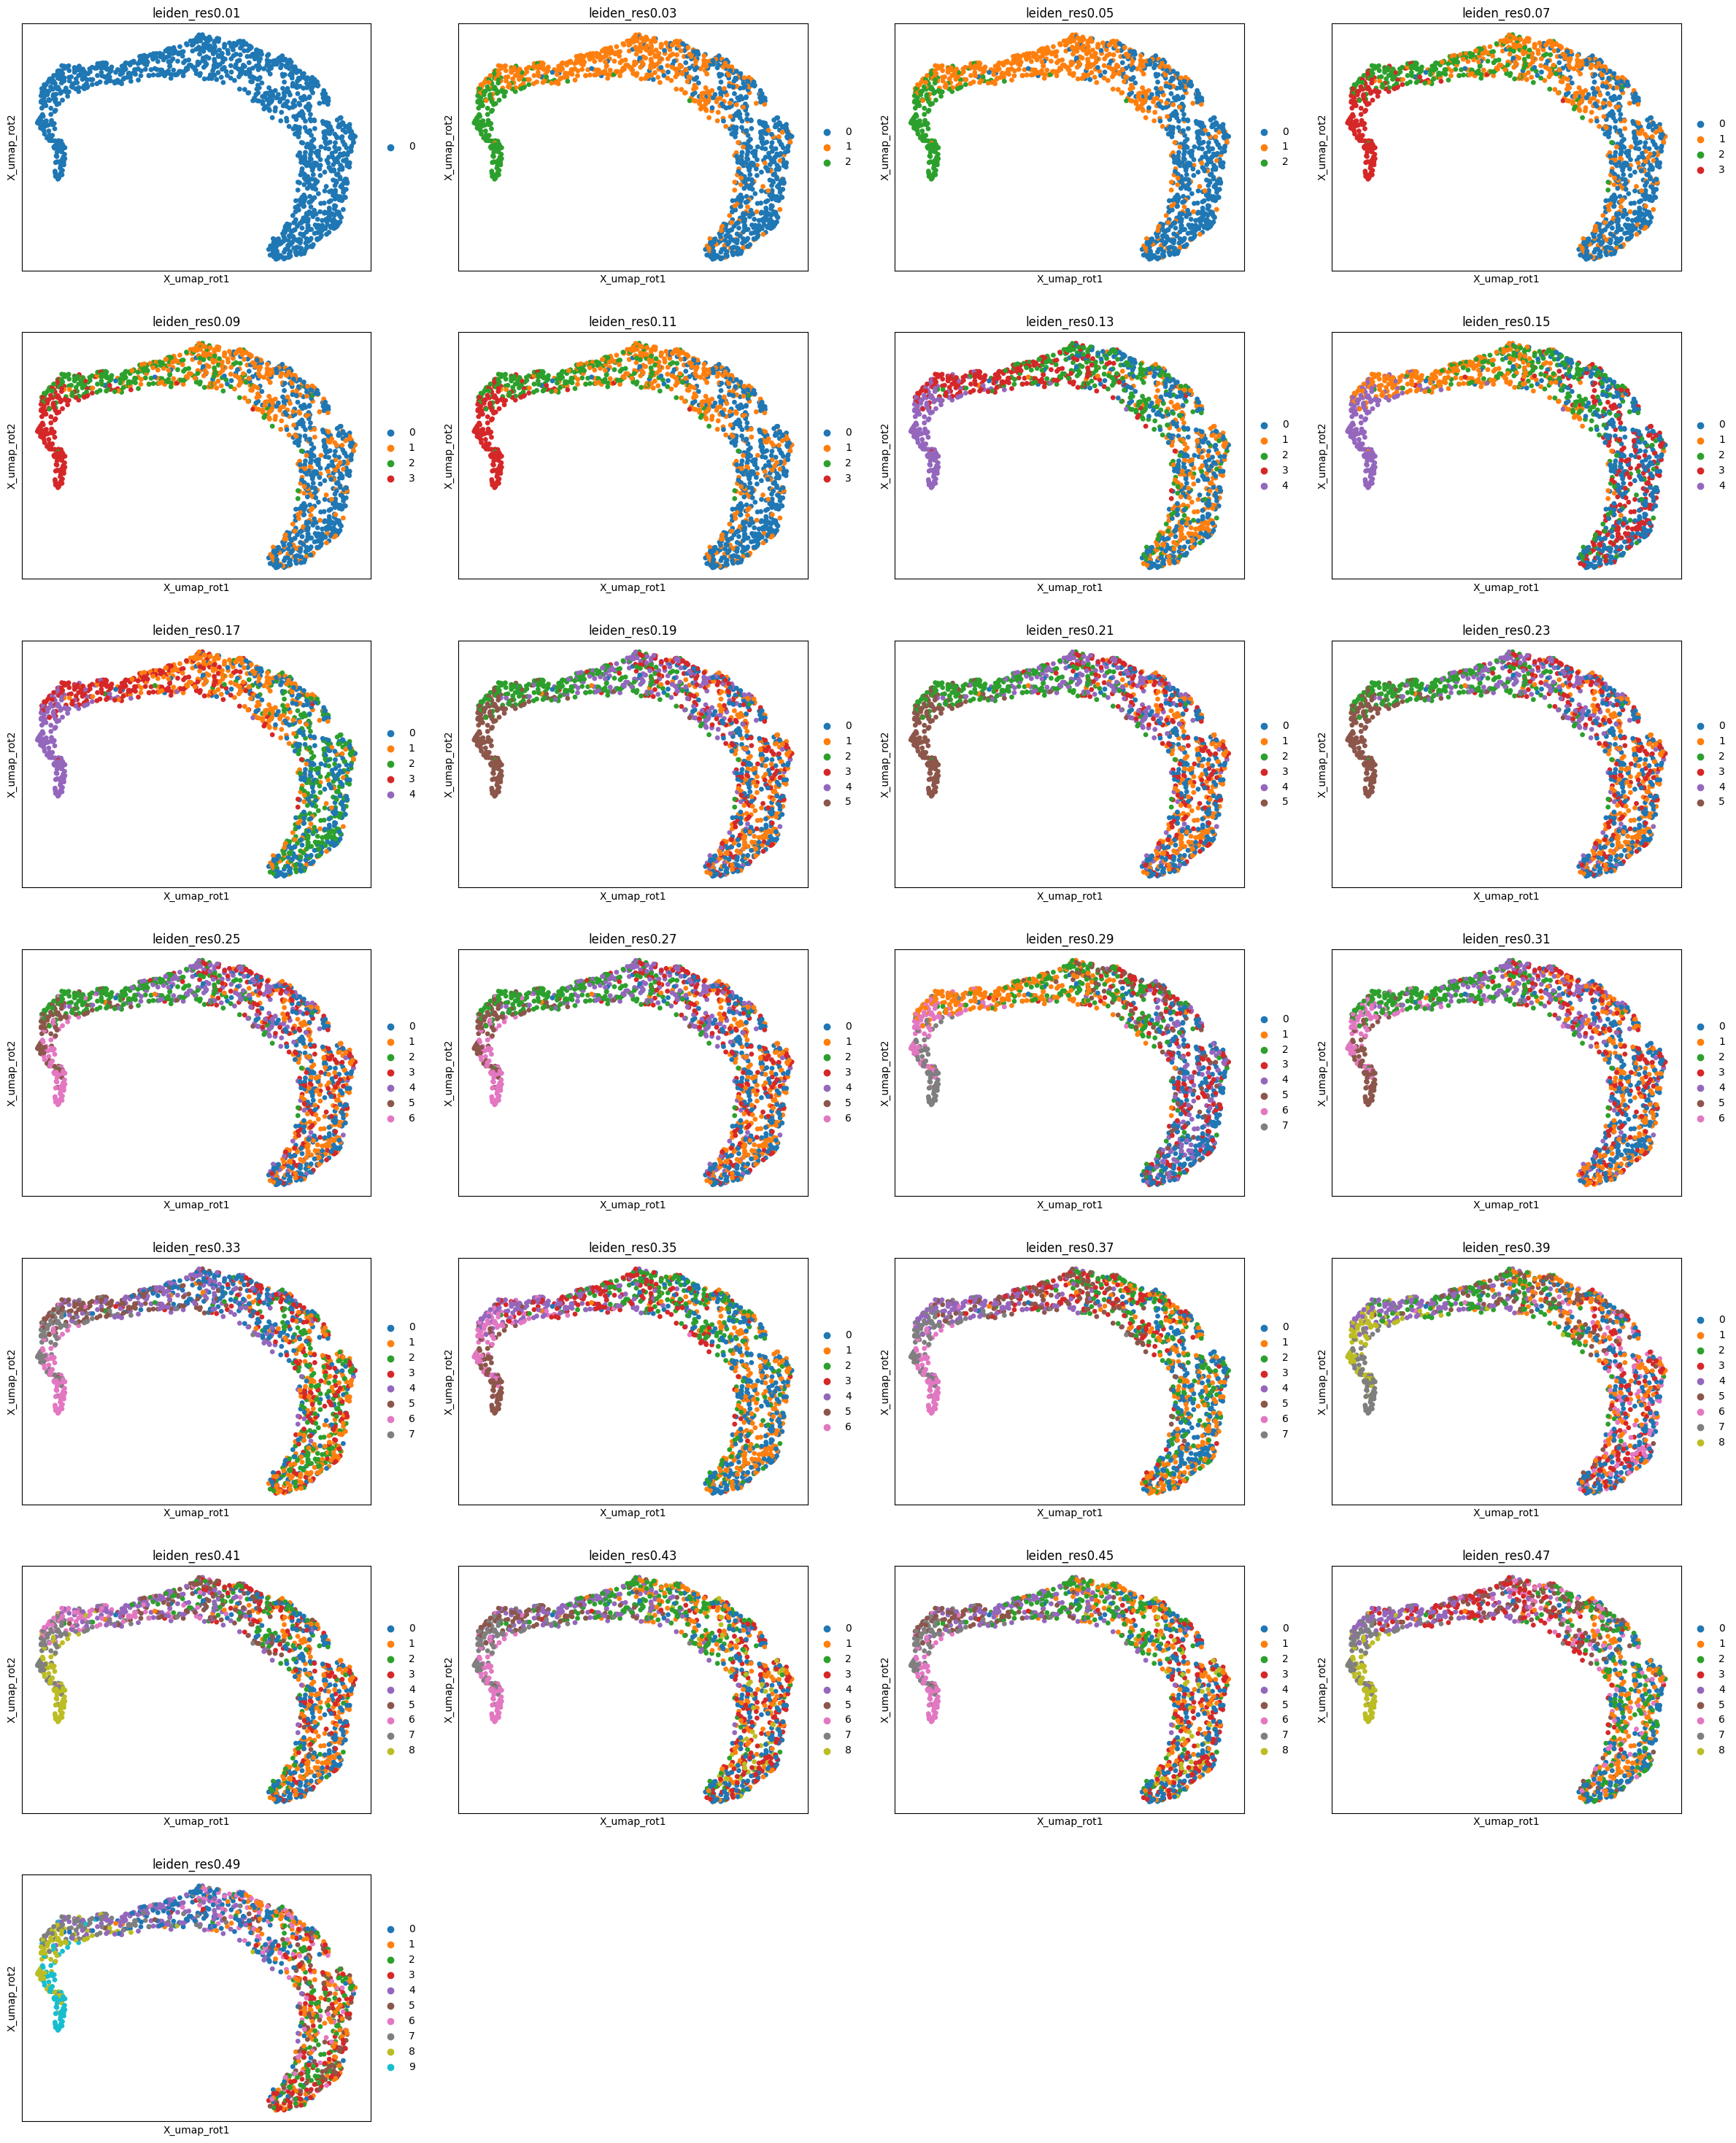

In [73]:
sc.pl.embedding(data_test, basis="X_umap_rot", color=[f"leiden_res{resolution}" for resolution in resolutions])
plt.show()

In [75]:
importlib.reload(co)
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(data_train, data_test, resolutions)

print(f"Optimal resolution {res_opt}")

resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 3 - Train: 0.466 - Test: 0.342 - Random: 0.184
resolution: 0.05 - clusters: 3 - Train: 0.458 - Test: 0.335 - Random: 0.178
resolution: 0.07 - clusters: 4 - Train: 0.445 - Test: 0.264 - Random: 0.124
resolution: 0.09 - clusters: 4 - Train: 0.439 - Test: 0.259 - Random: 0.118
resolution: 0.11 - clusters: 4 - Train: 0.434 - Test: 0.253 - Random: 0.113
resolution: 0.13 - clusters: 5 - Train: 0.426 - Test: 0.196 - Random: 0.078
resolution: 0.15 - clusters: 5 - Train: 0.419 - Test: 0.193 - Random: 0.074
resolution: 0.17 - clusters: 5 - Train: 0.42 - Test: 0.188 - Random: 0.07
resolution: 0.19 - clusters: 6 - Train: 0.407 - Test: 0.161 - Random: 0.053
resolution: 0.21 - clusters: 6 - Train: 0.404 - Test: 0.158 - Random: 0.049
resolution: 0.23 - clusters: 6 - Train: 0.4 - Test: 0.154 - Random: 0.045
resolution: 0.25 - clusters: 7 - Train: 0.381 - Test: 0.132 - Random: 0.039
resolution: 0.27 - 

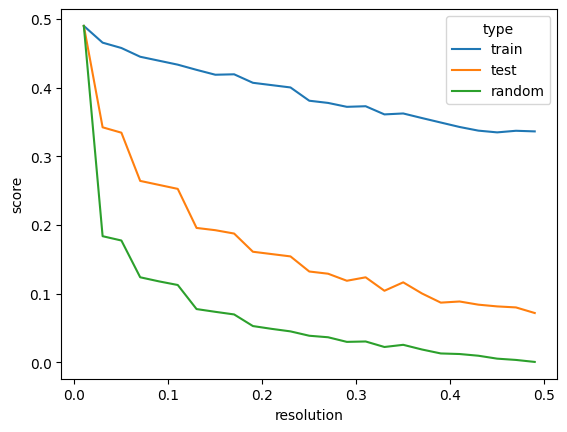

In [77]:
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
plt.show()

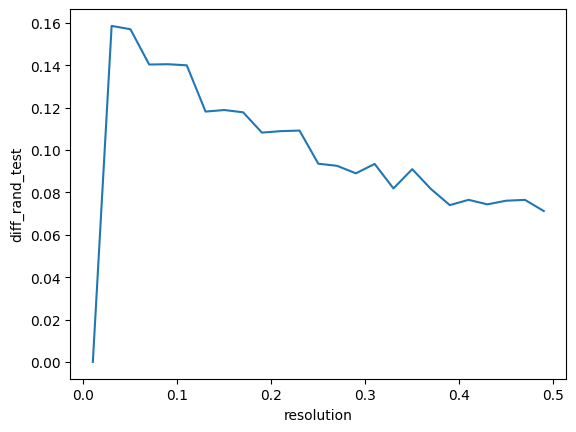

In [78]:
sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test")
plt.show()

In [76]:
sc.tl.leiden(data_gene, resolution=res_opt, key_added="leiden_opt")

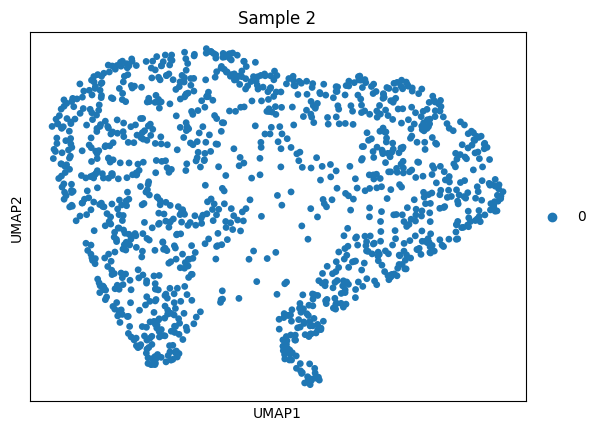

In [79]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 2")
plt.show()

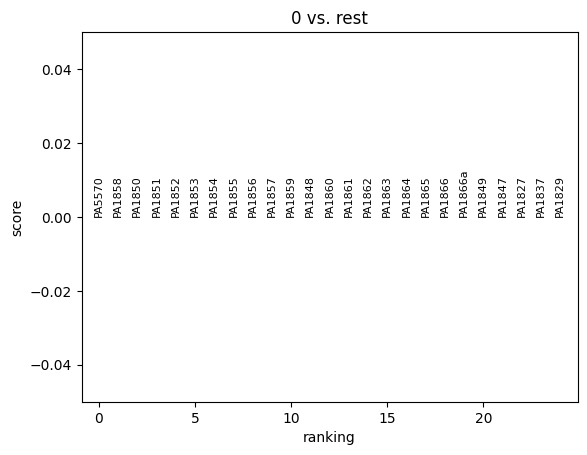

In [80]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)